In [15]:
# Import libraries
import os
import cv2
import numpy as np
import tifffile as tiff
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.utils import normalize
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split

from PIL import Image

In [16]:
# Paths to images and labels
images_dir = r'E:\datasets\data-water-001\data\images'
labels_dir = r'E:\datasets\data-water-001\data\labels'

In [17]:
# Load data
def load_data(images_dir, labels_dir):
    image_files = sorted(os.listdir(images_dir))
    label_files = sorted(os.listdir(labels_dir))
    
    images = []
    labels = []
    
    for img_file, lbl_file in zip(image_files, label_files):
        img_path = os.path.join(images_dir, img_file)
        lbl_path = os.path.join(labels_dir, lbl_file)
        
        # Read images and labels
        image = tiff.imread(img_path)  # Load .tif image
        label = Image.open(lbl_path).convert('L')  # Load .png label as grayscale
        label = np.array(label)  # Convert label to numpy array
        
        images.append(image)
        labels.append(label)
        
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

# Normalize data
def normalize_data(images, labels):
    images = normalize(images, axis=1)
    labels = labels / 255.0
    labels = np.expand_dims(labels, axis=-1)  # Add channel dimension
    return images, labels

In [18]:
# Load and normalize data
images, labels = load_data(images_dir, labels_dir)
images, labels = normalize_data(images, labels)

# Print shapes
print(f"Images shape: {images.shape}\nLabels shape: {labels.shape}")

Images shape: (306, 128, 128, 12)
Labels shape: (306, 128, 128, 1)


In [25]:
# Print the shape of the image (e.g., (height, width, channels))
print(f"Image shape: {img_array.shape}")

# Print each channel's index
for channel_index in range(img_array.shape[2]):
    print(f"Channel {channel_index + 1}")

Image shape: (128, 128, 12)
Channel 1
Channel 2
Channel 3
Channel 4
Channel 5
Channel 6
Channel 7
Channel 8
Channel 9
Channel 10
Channel 11
Channel 12


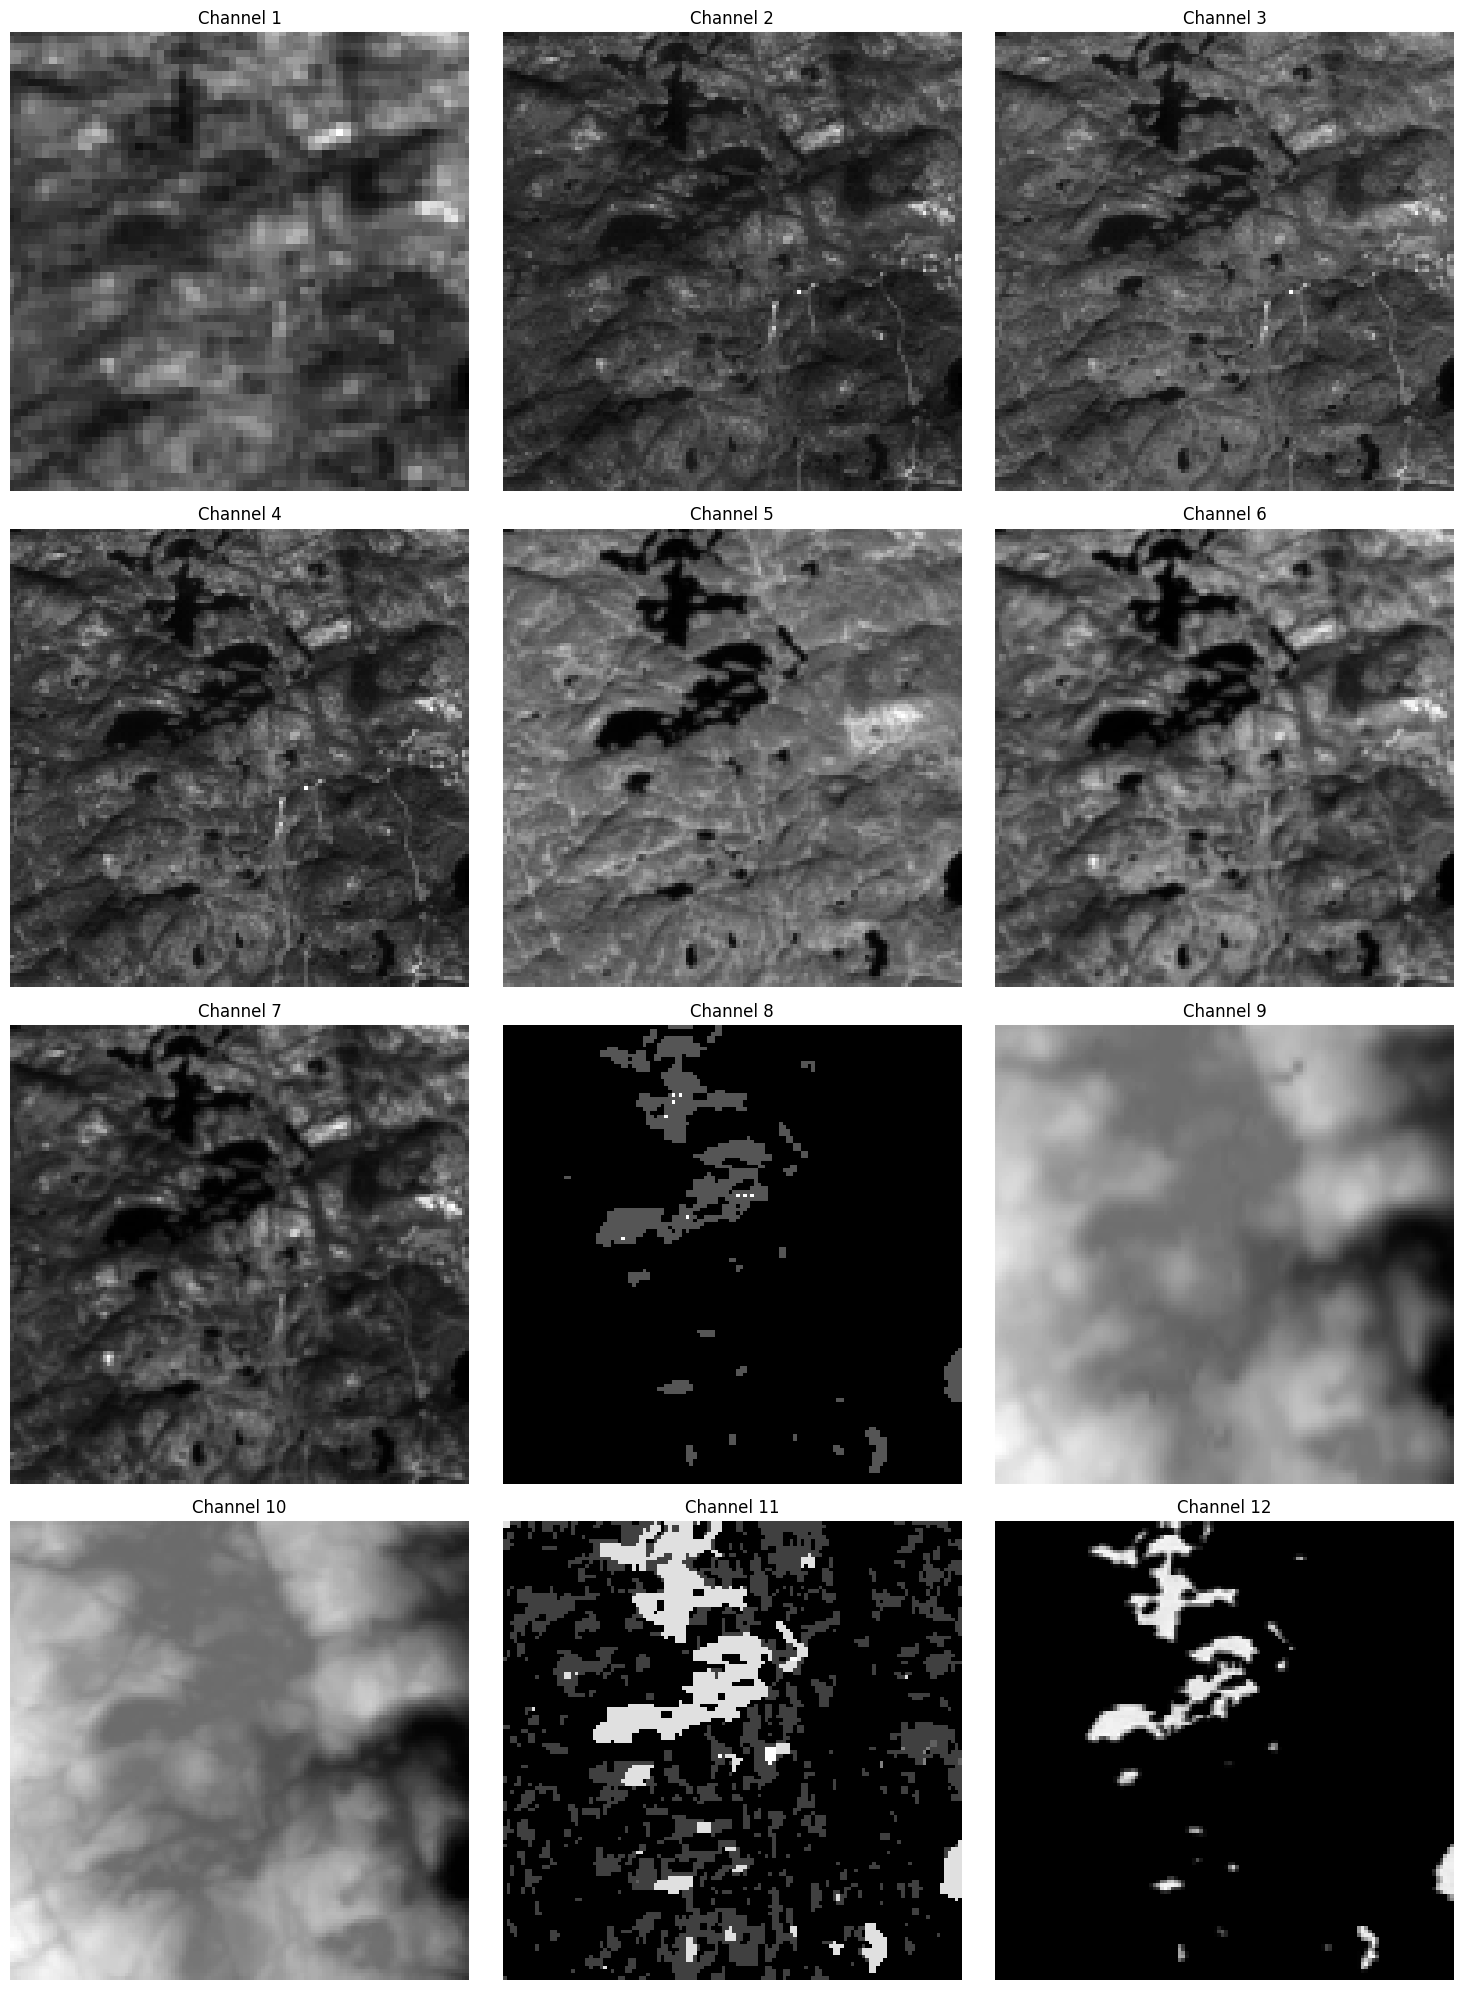

In [7]:
# Get a list of TIF files in the folder
tif_files = [f for f in os.listdir(images_dir) if f.endswith('.tif')]

# Sort the files to ensure consistent ordering (optional)
tif_files.sort()

# Select the first TIF image (you can choose another if needed)
img_path = os.path.join(images_dir, tif_files[0])

# Load the image using tifffile
img_array = tiff.imread(img_path)

# Number of channels in the image
num_channels = img_array.shape[2]

# Calculate number of rows and columns for subplots
num_cols = 3  # Number of columns in the grid
num_rows = int(np.ceil(num_channels / num_cols))  # Calculate rows based on number of columns

# Create a subplot with the calculated number of rows and columns
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))

# Flatten axes array for easy indexing
axes = axes.flatten()

# Loop through each channel and display it
for i in range(num_channels):
    channel_data = img_array[:, :, i]
    axes[i].imshow(channel_data, cmap='gray')
    axes[i].set_title(f'Channel {i + 1}')
    axes[i].axis('off')  # Hide axes ticks

# Turn off any unused subplots
for j in range(num_channels, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [19]:
# Define the DeepLabV3+ model with ResNet50 backbone
def deeplabv3_plus_with_custom_top(input_size=(128, 128, 12), num_classes=1):
    # Load the pre-trained ResNet50 model as backbone
    base_model = tf.keras.applications.ResNet50(input_shape=(128, 128, 64), include_top=False, weights=None)
    
    # Create a new input layer for the custom number of channels
    inputs = Input(shape=input_size)
    
    # Modify the input layer to accept 12 channels
    x = Conv2D(64, (1, 1), padding='same', activation='relu')(inputs)
    
    # Apply the ResNet50 model
    x = base_model(x)
    
    # Add custom top layers for segmentation
    # Decoder part
    x = UpSampling2D(size=(4, 4))(x)  # Adjust based on your specific architecture needs
    x = Conv2D(num_classes, (1, 1), padding='same')(x)
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(x)

    # Define the model
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


In [20]:
# Instantiate the model
model = deeplabv3_plus_with_custom_top()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 12)]    0         
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 64)      832       
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23779008  
                                                                 
 up_sampling2d_2 (UpSampling  (None, 16, 16, 2048)     0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 1)         2049      
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 1)         2         
                                                           

In [21]:
# Data augmentation
def augment_data(images, labels, batch_size):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    image_gen = datagen.flow(images, batch_size=batch_size, seed=1)
    label_gen = datagen.flow(labels, batch_size=batch_size, seed=1)
    
    return zip(image_gen, label_gen)

# Training and validation split
def split_data(images, labels, val_size=0.2):
    return train_test_split(images, labels, test_size=val_size, random_state=42)

In [22]:
# Load and preprocess data
images, labels = load_data(images_dir, labels_dir)
images, labels = normalize_data(images, labels)

# Split data
X_train, X_val, y_train, y_val = split_data(images, labels)

In [23]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Training parameters
batch_size = 8
epochs = 50

# Data augmentation
train_gen = augment_data(X_train, y_train, batch_size)

In [24]:
# train the model
history = model.fit(
    train_gen,
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=(X_val, y_val),
    epochs=epochs,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node 'binary_crossentropy/logistic_loss/mul' defined at (most recent call last):
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\atiya\AppData\Local\Temp\ipykernel_6136\4037479126.py", line 2, in <module>
      history = model.fit(
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\site-packages\keras\losses.py", line 2162, in binary_crossentropy
      backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "c:\Users\atiya\AppData\Local\anaconda3\envs\gpusupport\lib\site-packages\keras\backend.py", line 5677, in binary_crossentropy
      return tf.nn.sigmoid_cross_entropy_with_logits(
Node: 'binary_crossentropy/logistic_loss/mul'
required broadcastable shapes
	 [[{{node binary_crossentropy/logistic_loss/mul}}]] [Op:__inference_train_function_40870]

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [ ]:
# Define functions for visualization
def show_image_with_label(image_path, label_path):
    # Load the TIFF image
    img = tiff.imread(image_path)
    
    # If the image has more than 3 channels, select the first 3 for RGB display
    if img.shape[-1] > 3:
        img = img[..., :3]
    
    # Normalize the image for display
    img = img.astype(float)
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    
    # Load the label PNG image
    label_img = Image.open(label_path)
    label_img = np.array(label_img)

    # Display the image and its label side by side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(img)
    ax[0].set_title('TIFF Image')
    ax[0].axis('off')
    
    ax[1].imshow(label_img, cmap='gray')  # Assuming the label is grayscale; adjust if it's colored
    ax[1].set_title('Label Image')
    ax[1].axis('off')
    
    plt.show()

In [ ]:
# Test the visualization function
image_path = r'E:\datasets\data-water-001\data\images\0.tif'
label_path = r'E:\datasets\data-water-001\data\labels\0.png'

show_image_with_label(image_path, label_path)

In [ ]:
def preprocess_image(image_path, target_size):
    # Load the TIFF image
    img = tiff.imread(image_path)
    
    # Resize to the target size expected by the model
    img = cv2.resize(img, target_size)
    
    # Normalize
    img_array = img.astype('float32') / 255.0
    
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

def predict_and_show(image_path, label_path, target_size=(128, 128)):
    # Preprocess the image
    img_array = preprocess_image(image_path, target_size)
    
    # Make prediction
    prediction = model.predict(img_array)
    
    # Remove batch dimension and convert back to image
    predicted_img = np.squeeze(prediction, axis=0)
    predicted_img = array_to_img(predicted_img)
    
    # Load the label image
    label_img = Image.open(label_path)
    
    # Display the predicted image and the label side by side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].imshow(predicted_img, cmap='gray')
    ax[0].set_title('Predicted Image')
    ax[0].axis('off')
    
    ax[1].imshow(label_img, cmap='gray')
    ax[1].set_title('Label Image')
    ax[1].axis('off')
    
    plt.show()

In [ ]:
# Test the prediction and visualization function
predict_and_show(image_path, label_path)